## Example of adversarial attack based on input significance indicator 
This is a example for running ISI attack with Google Colab on mnist (or cifar10) dataset. 

## Preparation

Ensure that you have `tensorflow==1.13.1`, and `innvestigate` installed.

In [1]:
!pip -q install tensorflow==1.13.1 tensorflow-gpu==1.13.1 innvestigate

     |████████████████████████████████| 92.5MB 91kB/s 
     |████████████████████████████████| 345.2MB 50kB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 368kB 62.3MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 3.2MB 60.7MB/s 
     |████████████████████████████████| 317kB 61.8MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.chdir('./')
!git clone https://github.com/JoshuaCN/Input-Significance-Indicator-based-Attack
os.chdir('Input-Significance-Indicator-based-Attack')

Cloning into 'Input-Significance-Indicator-based-Attack'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 142 (delta 54), reused 68 (delta 32), pack-reused 36
Receiving objects: 100% (142/142), 29.09 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (68/68), done.


## Load datatset and train the model

In [4]:
import tensorflow as tf
import keras
from create_model import create_mnist_model, create_cifar_model


dataset = 'mnist' # or try on cifar10 by changing the dataset

# Create TF session and set as Keras backend session
sess = tf.Session()
keras.backend.set_session(sess)
if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = (x_train[..., None] / 127.5 - 1).astype('float32')
    x_test = (x_test[..., None] / 127.5 - 1).astype('float32')
    model = create_mnist_model(x_train[0].shape)
elif dataset == 'cifar10':
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    x_train = (x_train / 127.5 - 1).astype('float32')
    x_test = (x_test / 127.5 - 1).astype('float32')
    model = create_cifar_model(x_train[0].shape)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 137us/step - loss: 0.2409 - acc: 0.9308 - val_loss: 0.0607 - val_acc: 0.9823
Epoch 2/5
60000/60000 [==============================] - 2s 36us/step - loss: 0.0590 - acc: 0.9817 - val_loss: 0.0669 - val_acc: 0.9795
Epoch 3/5
60000/60000 [==============================] - 2s 36us/step - loss: 0.0402 - acc: 0.9872 - val_loss: 0.0331 - val_acc: 0.9889
Epoch 4/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.0290 - acc: 0.9904 - val_loss: 0.0345 - val_acc: 0.9877
Epoch 5/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.0238 - acc: 0.9922 - val_loss: 0.0304 - val_acc: 0.9905


## Untargeted ISI attack on the first 2k test images
there are currently two available indicators - sensitivity and relevance. We'll use relevance here since it addresses the saturation problem of gradients and generally works better. See our [paper](https://doi.org/10.1016/j.neucom.2020.01.040) for more illustration.

In [5]:
import time
from isi_attack import isi

keras.layers.core.K.set_learning_phase(0)
m = 2000
x = x_test[:m]

atk_params = {
    'indicator':'relevance', # for norm=0, you can also choose sensitivity as the indicator
    'norm':0,
    'max_iter':30,
    'batch_size':200,
}
t0 = time.time()
adv_x = isi(model, x=x, **atk_params)
t1 = time.time()
print('Runtime of generating 2k adversarial examples: %.3fs' % (t1-t0))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Runtime of generating 2k adversarial examples: 4.072s


## Evaluation of attack success rate and average $l_p$ distance

we only count $l_p$ distance on successful adversarial images.


Attack success rate:98.70%, Average L0 distance:11.78


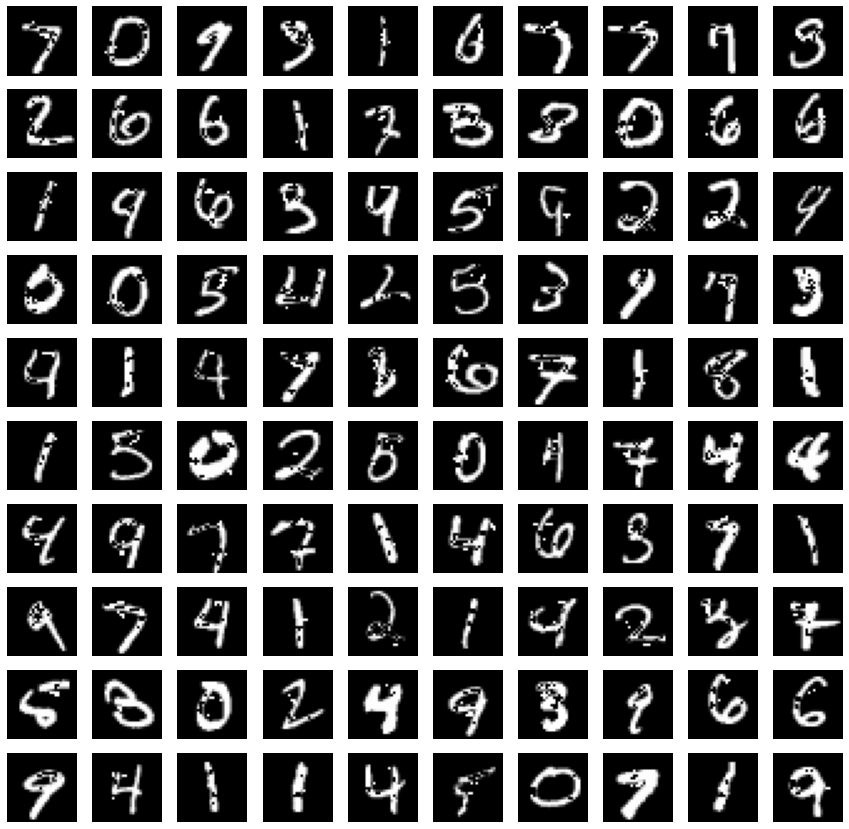

In [6]:
from eval import metrics, grid_visual

succ_rate, norm_distance = metrics(model,x,adv_x,norm=atk_params['norm'],targeted=False)
print('Attack success rate:%.2f%%, Average L0 distance:%.2f'%(succ_rate*100, norm_distance))
# plot the first 100 adversarial images
grid_visual((adv_x+1)/2)

## Comparison to Jacobian Saliency Map Method

JSMA is one of the benchmark of $l_0$-constrained adversarial attack, we'll use the implementation in [CleverHans](https://github.com/tensorflow/cleverhans) for a comparison.

In [7]:
!pip install -q cleverhans

     |████████████████████████████████| 204kB 8.6MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 163kB 8.7MB/s 


In [8]:
from cleverhans.attacks import SaliencyMapMethod as JSMA
from cleverhans.utils_keras import KerasModelWrapper
import numpy as np


clever = KerasModelWrapper(model)
jsma = JSMA(clever, sess=sess)
jsma_params = {'theta': 2., 'gamma': 30/784,
        'clip_min': -1., 'clip_max': 1.,
                }

# Batch run implementation of JSMA. JSMA can easily run into out of memory, 
# especially on large datasets, cut down batch_size if necessary. 
batch_size = 200
adv_x = np.zeros(x.shape)
t0 = time.time()
for batch_id in range(x.shape[0]//batch_size+1):
    adv_x[batch_id * batch_size:(batch_id + 1) * batch_size] = jsma.generate_np(
        x[batch_id * batch_size:(batch_id + 1) * batch_size], **jsma_params)
t1 = time.time()
print('Runtime of generating 2k adversarial examples: %.3fs' % (t1-t0))

[INFO 2020-09-10 12:57:17,001 cleverhans] Constructing new graph for attack SaliencyMapMethod


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Runtime of generating 2k adversarial examples: 20.653s


Attack success rate:60.55%, Average L0 distance:22.18


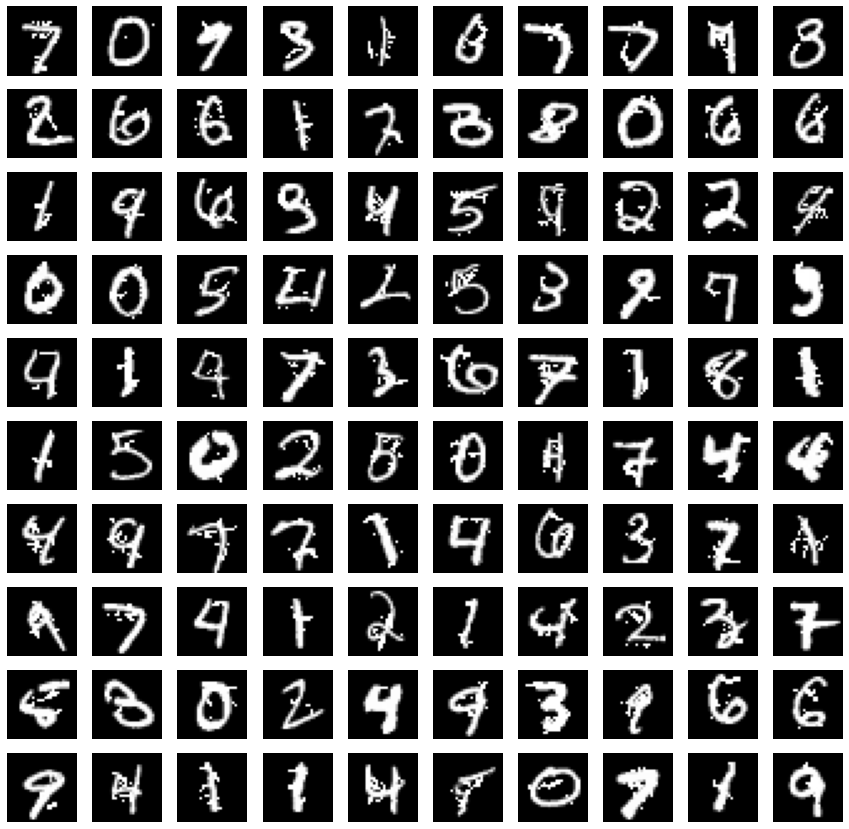

In [9]:
succ_rate, norm_distance = metrics(model,x,adv_x,norm=0,targeted=False)
print('Attack success rate:%.2f%%, Average L0 distance:%.2f'%(succ_rate*100, norm_distance))
grid_visual((adv_x+1)/2)

## Other showcases of ISI attack

ISI attack can also generate adversarial examples with other norm constraints such as $l_\infty$, 

in this case, additional parameters - `clip_values` and `eps` - are required.

In [10]:
from isi_attack import isi
from eval import metrics, grid_visual
import numpy as np


m = 2000
x = x_test[:m]
atk_params['norm'] = np.inf
atk_params['clip_values'] = (-1,1)
atk_params['eps'] = 0.06

adv_x = isi(model, x=x, **atk_params)

Attack success rate:100.00%, Average L_inf distance:0.35


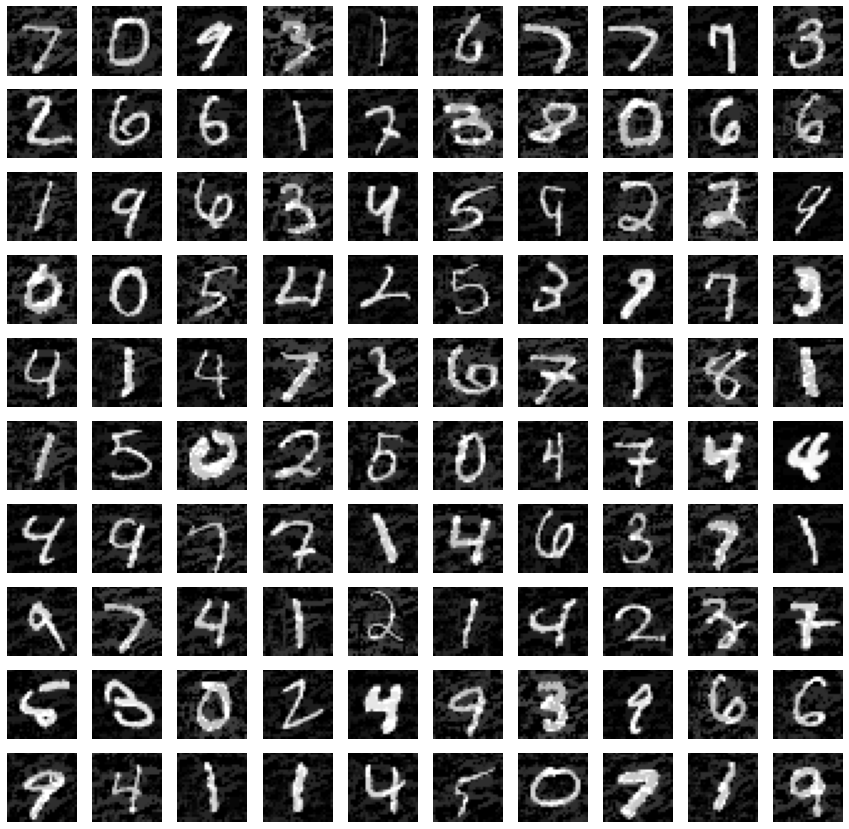

In [11]:
succ_rate, norm_distance = metrics(model,x,adv_x,norm=np.inf,targeted=False)
print('Attack success rate:%.2f%%, Average L_inf distance:%.2f'%(succ_rate*100, norm_distance))
grid_visual((adv_x+1)/2)

ISI attack can generate targeted adversarial examples as well, by providing target labels during generation.

In [12]:
indices = [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
m = np.size(indices)
x = x_test[indices,...]
adv_x = np.zeros(((m, 10) + x_train[0].shape))

atk_params['norm'] = 0
# targeted attack needs more perturbations to succeed
atk_params['max_iter'] = 40

# every class is set as the target in turn
for target in range(10):
    atk_params['y'] = target
    adv_x[:, target] = isi(model, x=x, **atk_params)
adv_x = np.reshape(adv_x, (10*m,)+x_train[0].shape)

Attack success rate:85.56%, Average L0 distance:20.73


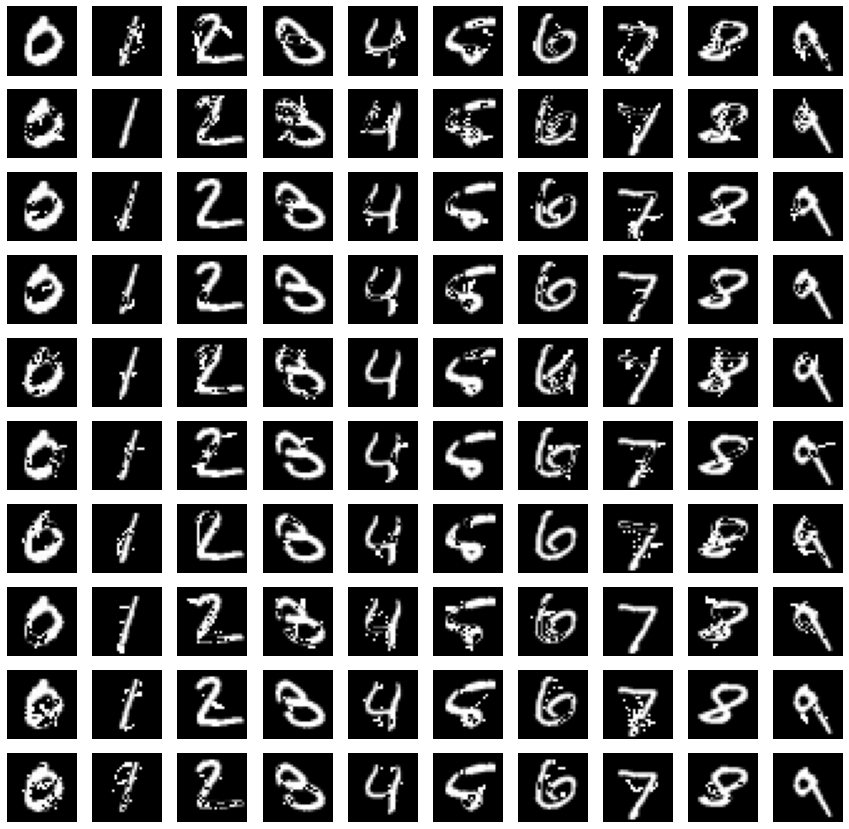

In [13]:
succ_rate, norm_distance = metrics(model,x,adv_x,norm=0,targeted=True)
print('Attack success rate:%.2f%%, Average L0 distance:%.2f'%(succ_rate*100, norm_distance))
grid_visual((adv_x+1)/2)